In [1]:
import os
from PIL import Image
from io import BytesIO
import base64
import io


from langchain_core.messages import HumanMessage
from langchain_core.documents import Document
from langchain_google_genai import ChatGoogleGenerativeAI

from typing import Union

In [2]:
def get_llm_vision():
  try:
    llm_vision = ChatGoogleGenerativeAI(model="gemini-1.5-flash",
                                        temperature=0.3,
                                        api_key=os.environ.get("GOOGLE_API_KEY"),
                                        max_output_tokens=100,
                                        )
    return llm_vision
  except Exception as e:
    print(e)
    return None

In [3]:
def get_image_base64(
    image_path: str
) -> Union[str, None]:
  from PIL import Image
  try:
    with Image.open(image_path) as img:
      if img.mode != "RGB":
        img = img.convert("RGB")
      img.thumbnail((1024, 1024))
      buffered = io.BytesIO()
      img.save(buffered, format="JPEG")
      img_byte = buffered.getvalue()
      return base64.b64encode(img_byte).decode('utf-8')
  except FileNotFoundError:
    print(f"File not found: {image_path}")
    return None
  except Exception as e:
    print(e)
    return None

In [5]:
!wget https://hoanghamobile.com/tin-tuc/wp-content/uploads/2024/04/anh-con-cho-51.jpg

--2025-05-07 21:40:53--  https://hoanghamobile.com/tin-tuc/wp-content/uploads/2024/04/anh-con-cho-51.jpg
Resolving hoanghamobile.com (hoanghamobile.com)... 103.28.37.130
Connecting to hoanghamobile.com (hoanghamobile.com)|103.28.37.130|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 125309 (122K) [image/jpeg]
Saving to: ‘anh-con-cho-51.jpg’

anh-con-cho-51.jpg  100%[===================>] 122.37K  57.6KB/s    in 2.1s    

2025-05-07 21:40:57 (57.6 KB/s) - ‘anh-con-cho-51.jpg’ saved [125309/125309]



In [4]:
img_path = "anh-con-cho-51.jpg"

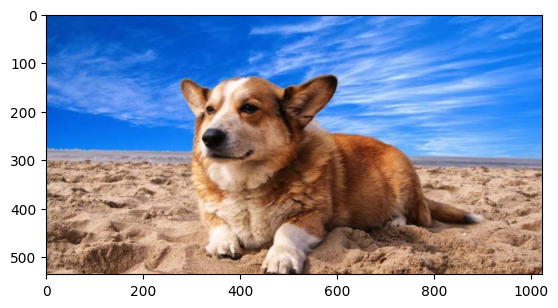

In [5]:
img = get_image_base64(img_path)
im = Image.open(BytesIO(base64.b64decode(img)))

import matplotlib.pyplot as plt
plt.imshow(im)
plt.show()

## With Gemini

In [11]:
from pydantic import BaseModel, Field


def generate_caption_with_gemini(
    image_path: str,
    prompt: str = "Describe this image in detail to be used as a caption. Focus on the main subjects, actions, and setting."
) -> Union[str, None]:

  class ImageCaption(BaseModel):
      image_captions: str = Field(description="The generated caption of image")

  # create llm_vision
  llm_vision = get_llm_vision()
  if not llm_vision:
    print("Model not found")
    return None
  llm_with_structed_output = llm_vision.with_structured_output(ImageCaption)

  image_b64 = get_image_base64(image_path)
  if not image_b64:
    return None

  message_content = [
        {
            "type": "text",
            "text": prompt,
        },
        {
            "type": "image_url",
            "image_url": f"data:image/jpeg;base64,{image_b64}"
        },
    ]

  human_message = HumanMessage(content=message_content)

  # sending request
  try:
    print("Sending Request")
    response = llm_with_structed_output.invoke([human_message])
    caption = response.image_captions
    print(f"Response: {caption}")
    return caption.strip() if isinstance(caption, str) else str(caption).strip()
  except Exception as e:
    print("Error: ", e)
    return None

In [12]:
generate_caption_with_gemini(img_path)

Sending Request
Response: A fluffy corgi lounges on a sandy beach, gazing toward a vibrant blue sky dotted with wispy clouds. The dog appears relaxed and content in the sunny outdoor setting.


'A fluffy corgi lounges on a sandy beach, gazing toward a vibrant blue sky dotted with wispy clouds. The dog appears relaxed and content in the sunny outdoor setting.'

## With Local Model

In [6]:
from huggingface_hub import notebook_login

notebook_login()

In [9]:
import torch
from accelerate.test_utils.testing import get_backend
from transformers import AutoProcessor # Lớn hơn AutoTokenizer (phù hợp cho mô hình MultiModal)
from transformers import AutoModelForCausalLM # mô hình chính

def get_llm_vision_local():
  checkpoint = "microsoft/git-base" # model checkpoint
  processor = AutoProcessor.from_pretrained(checkpoint)
  model = AutoModelForCausalLM.from_pretrained(checkpoint)

  return processor, model

In [10]:
processor, model = get_llm_vision_local()

/home/thangquang/CODE/multimodal-rag-baseline/env/lib/python3.10/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   1%|1         | 10.5M/707M [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:
from typing import Tuple

def generate_caption_with_local_model(
    image_path: str,
    prompt: str = "Describe this image in detail to be used as a caption. Focus on the main subjects, actions, and setting.",
    processor_and_model: Union[tuple, None] = None
) -> str:

  from accelerate.test_utils.testing import get_backend

  if not processor_and_model:
    processor, model = get_llm_vision_local()
  else:
    processor, model = processor_and_model

  img_for_local = Image.open(image_path)
  device, _, _ = get_backend()
  # Encode the prompt with the image data
  inputs = processor(text=prompt, images=img_for_local, return_tensors="pt").to(device)
  pixel_values = inputs.pixel_values
  generated_ids = model.generate(pixel_values=pixel_values, max_length=100)
  generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  return generated_caption

In [29]:
generate_caption_with_local_model(
    image_path=img_path,
    processor_and_model = (processor, model)
)

'dog laying in the sand'